<a href="https://colab.research.google.com/github/FBK-23/Crack-detection/blob/main/crack_detection_ibception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crack Detection using Deep Learning

In [ ]:
import keras
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

from keras.utils.vis_utils import plot_model

import os, shutil
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import models
from keras.preprocessing import image
import numpy as np
import sklearn.metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import seaborn

print(keras.__version__)
print(tf.__version__)

2.8.0
2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
conv_base = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [ ]:
plot_model(conv_base, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# The path to the directory where the training images are downloaded, change this as in your system
original_dataset_dir = '/content/drive/MyDrive/crack_data'
original_dataset_dir_positif = '/content/drive/MyDrive/crack_data/positif'
original_dataset_dir_negatif = '/content/drive/MyDrive/crack_data/negatif'

# The directory where we will store our train, test and validation images
base_dir = '/content/modele-ibception-v3'


# Directories for our training,validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training rust pictures
train_rust_dir = os.path.join(train_dir, 'positif')

# Directory with our training norust pictures
train_norust_dir = os.path.join(train_dir, 'negatif')

# Directory with our validation rust pictures
validation_rust_dir = os.path.join(validation_dir, 'positif')

# Directory with our validation norust pictures
validation_norust_dir = os.path.join(validation_dir, 'negatif')

# Directory with our test rust pictures
test_rust_dir = os.path.join(test_dir, 'positif')

# Directory with our test norust pictures
test_norust_dir = os.path.join(test_dir, 'negatif')

In [ ]:
# Needed only for first time

In [ ]:
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)
os.mkdir(train_rust_dir)
os.mkdir(train_norust_dir)
os.mkdir(validation_rust_dir)
os.mkdir(validation_norust_dir)
os.mkdir(test_rust_dir)
os.mkdir(test_norust_dir)

# Needed only for first time

In [ ]:
# Copy first 70 rust images to train_rust_dir
fnames = ['positif.{}.jpg'.format(i) for i in range(448)]
for fname in fnames:
    
    src = os.path.join(original_dataset_dir_positif, fname)
    dst = os.path.join(train_rust_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 5 rust images to validation_rust_dir
fnames = ['positif.{}.jpg'.format(i) for i in range(10, 405)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_positif, fname)
    dst = os.path.join(validation_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 6 rust images to test_rust_dir
fnames = ['positif.{}.jpg'.format(i) for i in range(30, 423)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_positif, fname)
    dst = os.path.join(test_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 60 non-rust images to train_norust_dir
fnames = ['negative.{}.jpg'.format(i) for i in range(455)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_negatif, fname)
    dst = os.path.join(train_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 5 norust images to validation_norust_dir
fnames = ['negative.{}.jpg'.format(i) for i in range(1, 120)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_negatif, fname)
    dst = os.path.join(validation_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 5 norust images to test_norust_dir
fnames = ['negative.{}.jpg'.format(i) for i in range(0, 209)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_negatif, fname)
    dst = os.path.join(test_norust_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
print('total training positive images:', len(os.listdir(train_rust_dir)))
print('total training negative images:', len(os.listdir(train_norust_dir)))
print('total validation positive images:', len(os.listdir(validation_rust_dir)))
print('total validation negative images:', len(os.listdir(validation_norust_dir)))
print('total test positive images:', len(os.listdir(test_rust_dir)))
print('total test negative images:', len(os.listdir(test_norust_dir)))

total training positive images: 448
total training negative images: 455
total validation positive images: 395
total validation negative images: 119
total test positive images: 420
total test negative images: 209


We will leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. 

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               13107456  
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 36,695,425
Trainable params: 13,107,713
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [ ]:
conv_base.trainable = False 

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [ ]:
base_dir = '/content/modele-resnet50'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

 #       save_to_dir='/home/anirban/rustnorust_b/images')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 903 images belonging to 2 classes.
Found 514 images belonging to 2 classes.


In [ ]:
from time import time
from keras.callbacks import TensorBoard
from tensorflow.keras import optimizers
#callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.00001,patience=5,mode='min')]
tensorboard = keras.callbacks.TensorBoard(log_dir='/output/{}'.format(time()))

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])

history = model.fit_generator(train_generator,steps_per_epoch=10,epochs=15,validation_data=validation_generator,validation_steps=20,verbose=2,callbacks=[tensorboard])

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


In [ ]:
model.save('/content/drive/MyDrive/crack_data/modele-resnet50.h5') 

Let's plot our results again:

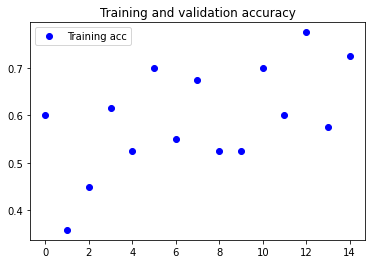

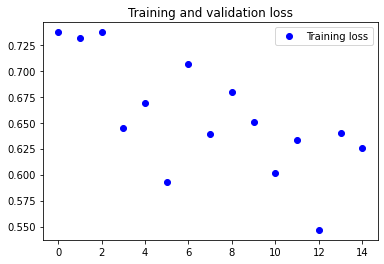

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

## If you want to try running the prediction from the saved model to validate the results, start from this step.

In [ ]:
model = models.load_model('/content/drive/MyDrive/crack_data/modele-resnet50.h5')

crack prob = [[0.38617003]]
This is a no Crack image


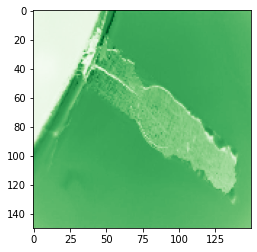

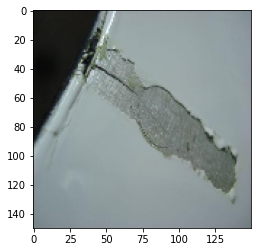

In [ ]:
%matplotlib inline
img_path = '/content/drive/MyDrive/crack_data/test_crack/positive.0005.jpg'
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
crack_prob = model.predict(test_x)
print('crack prob =' ,crack_prob)
if (crack_prob > 0.5):
    print("This is a Crack image")
    I1=img.convert('L') # 'L' for gray scale mode
    plt.imshow(np.asarray(I1), cmap='Reds')
   # plt.savefig('/content/drive/MyDrive/crack_data/Resultat_crack/positif-rouge/crack.6.jpg')
    plt.show()
    #img.save('/content/drive/MyDrive/crack_data/Resultat_crack/positif-non-rouge/crack.6.jpg')
    
else:
    print("This is a no Crack image")
    I1=img.convert('L') # 'L' for gray scale mode
    plt.imshow(np.asarray(I1), cmap='Greens')
    #plt.savefig('/content/drive/MyDrive/crack_data/Resultat_crack/negatif-vert/nocrack.1.jpg')
    plt.show()
    #img.save('/content/drive/MyDrive/crack_data/Resultat_crack/negatif-non-vert/no-crack.1.jpg')
    
    


plt.imshow(img)


In [ ]:
base_dir = '/content/modele-vgg16'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')
       # save_to_dir='/home/anirban/rustnorust_b/images')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 903 images belonging to 2 classes.
Found 404 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        shuffle=False, 
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=10)
print('test acc:', test_acc)

Found 449 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


test acc: 1.0


In [ ]:
test_data_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        shuffle=False, # v imp : do not shuffle in case of test data, when measuring precision and recall
        class_mode='binary')

test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)

val_preds = np.zeros((predictions.shape[0],1))
for i in range(predictions.shape[0]):
    if predictions[i]>0.5:
        val_preds[i] = 1
    else:
        val_preds[i] = 0

val_trues = test_data_generator.classes

labels = test_data_generator.class_indices.keys()


Found 449 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
precision - [0.97 1.  ]
recall - [1. 1.]


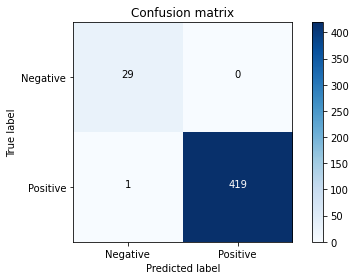

In [ ]:
# Compute confusion matrix
class_names = ['Negative','Positive']
cnf_matrix = confusion_matrix(val_trues, val_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

precision = TP / ( TP+ FP )
recall =  TP/ ( TP + FN )

print('precision -', precision)
print('recall -', recall)

In [ ]:
report = classification_report(val_trues, val_preds, target_names=labels)
print(report) 

              precision    recall  f1-score   support

     negatif       0.97      1.00      0.98        29
     positif       1.00      1.00      1.00       420

    accuracy                           1.00       449
   macro avg       0.98      1.00      0.99       449
weighted avg       1.00      1.00      1.00       449



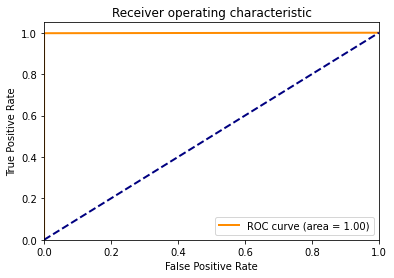

In [ ]:
true_labels = val_trues
scores = val_preds
### actual code for roc + threshold charts start here 
# compute fpr, tpr, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr) # compute area under the curve
 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()